In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.cm as cm
cmap = cm.tab10


In [87]:
## custom packages
src_dir = os.path.join(os.pardir,'src')
sys.path[0] = src_dir

from data_io_ts import *
from stats import xdata_to_xnx, x_autocorr_sm_ext, determine_tau
from powerlaw_fit import *

# Plot setup

In [5]:
###########
## Setup ##
###########
# number of pt for column in latex-document
fig_width_pt = 510  # single-column:510, double-column: 246; Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.1/72.27 # Convert pt to inches
width_vs_height = (np.sqrt(5)-1.0)/2.#(np.sqrt(5)-1.0)/2.0 # Ratio of height/width [(np.sqrt(5)-1.0)/2.0]
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = width_vs_height*fig_width  # height in inches
fig_size = [fig_width,fig_height]

# here you can set the parameters of the plot (fontsizes,...) in pt
params = {'backend': 'ps',
          'axes.titlesize':16,
          'axes.labelsize': 16,
          'text.fontsize': 16,
          'legend.fontsize': 16,
#           'figtext.fontsize': 12,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          
          'text.usetex': True,
          'ps.usedistiller' : 'xpdf',
          'figure.figsize': fig_size,
          'text.latex.unicode':True,
          'text.latex.preamble': [r'\usepackage{bm}'],
          
          'xtick.direction':'out',
          'ytick.direction':'out',
          
          'axes.spines.right' : False,
          'axes.spines.top' : False
         }
plt.rcParams.update(params)


lw = 2
ms = 2

/home/martin/anaconda3/envs/fitting/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  mplDeprecation)


# Get a dataset:

We generate synthetic data that follows a power-law:

$p(x) \propto x^{-\alpha }$.

The data is generated using a Markov-process such that we can include correlations via a paramter $\mu$.

In the paper, we use $\mu = 0.01$.

For $\mu = 1$, we recover the case of independently sampled data. 

In [24]:
label = 'mcmc_zipf'
k = 5 ## number of neighbors for correlated step
Ntypes = 10**3 ## maximum number of symbols
Ntokens = 10**5 ## number of samples
alpha = 1.5 ## powerlaw exponent
mu = 0.01 ## correlation parameter
# list_mu = [0.01,1.0] ## correlated and uncorrelated case

dict_args = {'Ntypes':Ntypes,
             'Ntokens':Ntokens,
             'alpha':alpha,
             'mu':mu,
             'k':k,
             'src_dir':src_dir,
     }
x_data = get_xdata_ts_wrapper(label,dict_args)


# Plot the distribution and the fit


In [25]:
## Empirical distribution
xmin = 1
xmax = Ntypes
x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)

N = np.sum(nx)
px = nx/N
Fx = 1-np.cumsum(px)

## Fit: powerlaw

result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax)
alpha = result['alpha']
px_fit = pdf_power_disc(x,xmin,xmax,alpha)
Fx_fit = cdf_power_disc(x,xmin,xmax,alpha)

Text(0.6,0.6,'$\\propto x^{-\\alpha}$')

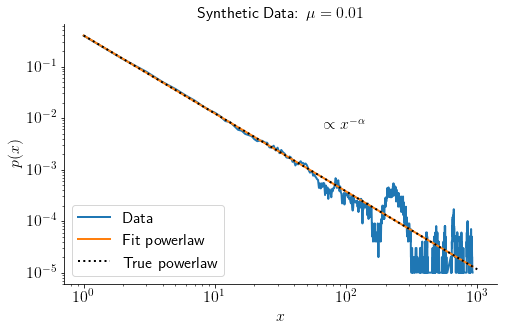

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

## Plot the distribution
x_ = x
y_ = px

c_ = cmap(0)
ax.plot(x_,y_,marker='o',ms=0,lw=2,c = c_,label = 'Data')

## Plot the fit
c_ = cmap(1)
x_ = x
y_ = px_fit
plt.plot(x_,y_,lw=2,c=c_, label = 'Fit powerlaw')

## Plot the truth
c_ = 'black'
x_ = np.arange(1,Ntypes+1,1)
y_ = x_**(-alpha)
y_ /= np.sum(y_)
plt.plot(x_,y_,lw=2,c=c_, ls=':', label = 'True powerlaw')


## Layout stuff
ax.legend(loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

# ax.set_xlim(1,1000)
# ax.set_ylim(10**(-5),1.2)

ax.set_xlabel(r'$x$')#,labelpad=0)
ax.set_ylabel(r'$p(x)$')
ax.set_title(r'Synthetic Data: $\mu = %s$'%(mu))

x_annot_formula = 0.6
y_annot_formula = 0.6
ax.annotate(r'$\propto x^{-\alpha}$',xy=(x_annot_formula,y_annot_formula),xycoords = 'axes fraction')#,size=8)

# Autocorrelation function

Note that we are taking the $\log x$ to calculate the autocorrelation (this leads to a more conservative estimation of $\tau^*)$.

Note that different realizations can lead to different autocorrelation times.

In [31]:
nrep = 10**3
q1,q2 = 1,99
result = x_autocorr_sm_ext(np.log(x_data),nrep=nrep,q=[q1,q2])
x = result['tau']
y_mu,y_1,y_2 = result['C']
y_mu_rand,y_1_rand,y_2_rand = result['C_rand']

## here we calculate from t=0,1,...,t^* where t^* is the first point
## where true C(t) is within the q-percentiles of the random

# ind_t_star = np.where( (y_mu<=y_2_rand)&(y_mu>=y_1_rand) )[0][1]
ind_t_star = np.where(y_1<=y_2_rand)[0][2]
tau_star = x[ind_t_star]

print('Autocorrelation time: ',tau_star)



Autocorrelation time:  272


Text(0.8,0.6,'$\\tau^*=272$')

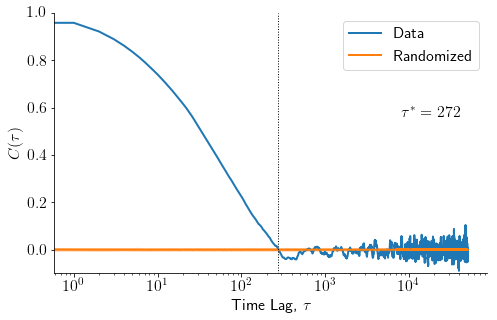

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

alpha_val = .5
## Plot the empirical autocorrelation
x_ = x
y_ = y_mu
z1_ = y_1
z2_ = y_2
c_ = cmap(0)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Data')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)



## Plot the randomized autocorrelation
x_ = x
y_ = y_mu_rand
z1_ = y_1_rand
z2_ = y_2_rand
c_ = cmap(1)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Randomized')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)


ax.plot([tau_star,tau_star],[-1,1],lw=1,color='black',ls=':')


## Layout stuff
ax.legend(loc='upper right')

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel(r'Time Lag, $\tau$')#,labelpad=0)
ax.set_ylabel(r'$C(\tau)$')
ax.set_ylim(-0.1,1.)


x_annot_tau = 0.8
y_annot_tau = 0.6
ax.annotate(r'$\tau^*=%s$'%(int(tau_star)),xy=(x_annot_tau,y_annot_tau),xycoords = 'axes fraction')




# Subsampling the data

### p-value for the original dataset

In [35]:
nrep_synth = 100 ## number of synthetic datasets to generate for empirical p-value

x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)

result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax,nrep_synth=nrep_synth)

alpha = result['alpha'] ## fitted parameter alpha
pval = result['pval'] ## p-value
KS = result['KS'] ## KS-distance

print('Original dataset. N = %s'%(N))
print('Empirical p-value from %s synthetic datasets: '%(nrep_synth), pval)

Original dataset. N = 100001
Empirical p-value from 100 synthetic datasets:  0.0


### p-value from subsampled dataset

Note that the subsampling generates different datasets each time; therefore there will be variability in the measured p-value

In [36]:
p_sub = 1./tau_star ## 0 ... 1 (keep nothing ... keep all); we set 1/tau_star
N_sub = int(p_sub*N)
nrep_synth = 100 ## number of synthetic datasets to generate for empirical p-value


## subsample -- take N_sub samples from x_data without replacement
x_data_sub = np.random.choice(x_data,size=N_sub,replace=False)
x,nx = xdata_to_xnx(x_data_sub,norm=False,xmin=xmin,xmax=xmax)
result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax,nrep_synth=nrep_synth)

alpha = result['alpha'] ## fitted parameter alpha
pval = result['pval'] ## p-value
KS = result['KS'] ## KS-distance

print(r'Subsampled dataset: n = %s (n/N ~ %s)'%(N_sub,p_sub)) 
print('Empirical p-value from %s synthetic datasets: '%(nrep_synth), pval)

Subsampled dataset: n = 367 (n/N ~ 0.003676470588235294)
Empirical p-value from 100 synthetic datasets:  0.89


# Compare correlated and uncorrelated data

In [38]:
list_mu = [0.01,1.0] ## correlated and uncorrelated case


label = 'mcmc_zipf'
k = 5 ## number of neighbors for correlated step
Ntypes = 10**3 ## maximum number of symbols
Ntokens = 10**5 ## number of samples
alpha = 1.5 ## powerlaw exponent

Text(0.6,0.6,'$\\propto x^{-\\alpha}$')

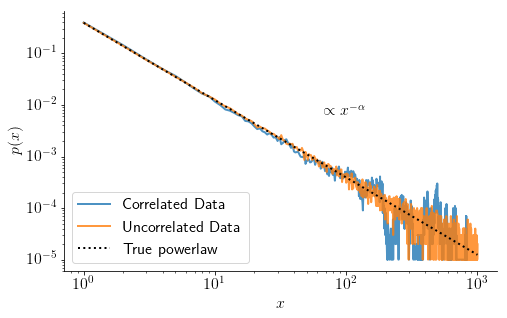

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)


for i_mu , mu in enumerate(list_mu):
    dict_args = {'Ntypes':Ntypes,
             'Ntokens':Ntokens,
             'alpha':alpha,
             'mu':mu,
             'k':k,
             'src_dir':src_dir,
     }
    x_data = get_xdata_ts_wrapper(label,dict_args)
    xmin = 1
    xmax = Ntypes
    x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)

    N = np.sum(nx)
    px = nx/N
    
    

    ## Plot the distribution
    x_ = x
    y_ = px

    c_ = cmap(i_mu)
    if mu == 1.:
        l_ = 'Uncorrelated Data'
    else:
        l_ = 'Correlated Data'
    ax.plot(x_,y_,marker='o',ms=0,lw=2,c = c_,label = l_,alpha=0.8)

## Plot the truth
c_ = 'black'
x_ = np.arange(1,Ntypes+1,1)
y_ = x_**(-alpha)
y_ /= np.sum(y_)
plt.plot(x_,y_,lw=2,c=c_, ls=':', label = 'True powerlaw')


## Layout stuff
ax.legend(loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

# ax.set_xlim(1,1000)
# ax.set_ylim(10**(-5),1.2)

ax.set_xlabel(r'$x$')#,labelpad=0)
ax.set_ylabel(r'$p(x)$')

x_annot_formula = 0.6
y_annot_formula = 0.6
ax.annotate(r'$\propto x^{-\alpha}$',xy=(x_annot_formula,y_annot_formula),xycoords = 'axes fraction')#,size=8)

# As a function of datasize

### KS- distance

### fitted exponent $\hat{\alpha}$

We generate synthetic datasets of different length.

We fit a powerlaw and get the KS-distance and the powerlaw-exponent.

Note this could take a while to run. 

In [73]:
n = 10 # number of realizations; in the paper we choose n = 100
list_mu = [0.01,1.0] ## correlated and uncorrelated case


label = 'mcmc_zipf'
k = 5 ## number of neighbors for correlated step
Ntypes = 10**3 ## maximum number of symbols
# Ntokens = 10**5 ## number of samples
alpha = 1.5 ## powerlaw exponent


## vary Ntokens
n_Nmax = 15
n_Nmin=5
list_Ntokens = np.logspace(n_Nmin,n_Nmax,n_Nmax-n_Nmin+1,base=2).astype('int')
Nmax = list_Ntokens[-1]

xmin = 1
xmax = Ntypes

In [74]:
arr_KS = np.zeros(( n, len(list_Ntokens),len(list_mu) ))
arr_alpha = np.zeros(( n, len(list_Ntokens),len(list_mu) ))
for i_mu , mu in enumerate(list_mu):
    for i_n in range(n):
        dict_args = {'Ntypes':Ntypes,
                     'Ntokens':Nmax,
                     'alpha':alpha,
                     'mu':mu,
                     'k':k,
                      'src_dir':src_dir,
                 }
        x_data = get_xdata_ts_wrapper(label,dict_args)
        for i_Ntokens,Ntokens in enumerate(list_Ntokens):
            x_data_tmp = x_data[:Ntokens]
            x,nx = xdata_to_xnx(x_data_tmp,norm=False,xmin=xmin,xmax=xmax)
            result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax)
            alpha = result['alpha']
            KS = result['KS']
            arr_KS[i_n,i_Ntokens,i_mu] = KS
            arr_alpha[i_n,i_Ntokens,i_mu] = alpha

Text(0.6,0.6,'$\\propto N^{-1/2}$')

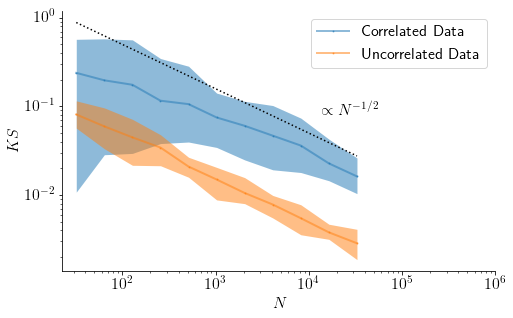

In [77]:
## plot the KS-distance
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

# ax_in.set_xticklabels([])
for i_mu,mu in enumerate(list_mu):
   
    x_ = list_Ntokens
    Z = arr_KS[:,:,i_mu]
    y_ = np.mean(Z,axis=0)
    y1_,y2_ = np.percentile(Z,q=[5,95],axis=0)
    c_ = cmap(i_mu)
    if mu == 1.:
        l_ = 'Uncorrelated Data'
    else:
        l_ = 'Correlated Data'
    ax.plot(x_,y_,marker='o',ms=1,lw=lw,c = c_,label=l_,alpha=alpha_val)
    ax.fill_between(x_,y1_,y2_,color=c_,alpha=0.5,lw=0)

ax.plot(x_,5*x_**(-0.5),ls=':',color='black')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10**2,10**3,10**4,10**5,10**6])
# ax.set_ylim(0.5*10**(-4),10**0)

ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$KS$')

ax.legend()

ax.annotate(r'$\propto N^{-1/2}$',xy=(0.6,0.6),xycoords = 'axes fraction')

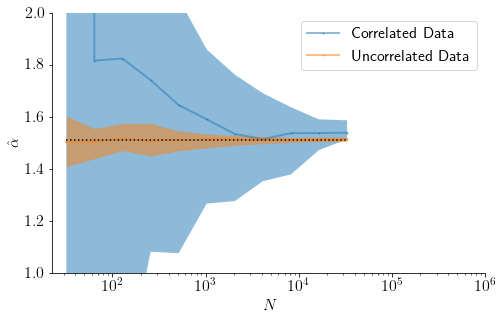

In [78]:
## plot the fitted exponent
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

# ax_in.set_xticklabels([])
for i_mu,mu in enumerate(list_mu):
   
    x_ = list_Ntokens
    Z = arr_alpha[:,:,i_mu]
    y_ = np.mean(Z,axis=0)
    y1_,y2_ = np.percentile(Z,q=[5,95],axis=0)
    c_ = cmap(i_mu)
    if mu == 1.:
        l_ = 'Uncorrelated Data'
    else:
        l_ = 'Correlated Data'
    ax.plot(x_,y_,marker='o',ms=1,lw=lw,c = c_,label=l_,alpha=alpha_val)
    ax.fill_between(x_,y1_,y2_,color=c_,alpha=0.5,lw=0)

ax.plot(x_,alpha+0.0*x_,ls=':',color='black')

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xticks([10**2,10**3,10**4,10**5,10**6])
ax.set_ylim(1,2)

ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\hat{\alpha}$')

ax.legend()



# Distribution of p-values

We generate n_rep synthetic datasets. We fit each dataset according to the standard procedure and obtain an empirical p-value (based on n_rep_synth comparisons of independently drawn data using the fitted exponent).

Since the null hypothesis is true (data comes from the powerlaw), we should obtain an approximately flat distribution of p-values.

- for the original data, we get a peak at 0
- for the decorrelated (subsampled) data, we get an approximately flat distribution


Note, that this will probably take a while to run.


In [97]:
n_rep = 100 # number of realizations; in the paper we choose n = 100
n_rep_synth = 100 ## number of datasets for calculating the empirical p-value in each realization
n_rep_auto = 100
mu = 0.01

label = 'mcmc_zipf'
k = 5 ## number of neighbors for correlated step
Ntypes = 10**3 ## maximum number of symbols
Ntokens = 10**4 ## number of samples
alpha = 1.5 ## powerlaw exponent

xmin = 1
xmax = Ntypes

dict_args = {'Ntypes':Ntypes,
             'Ntokens':Ntokens,
             'alpha':alpha,
             'mu':mu,
             'k':k,
             'src_dir':src_dir,
             'log':False}

In [98]:
list_pval = []
list_pval_sub = []

for i_n_rep in range(n_rep):
    ## draw the data
    x_data = get_xdata_ts_wrapper(label,dict_args)
    
    ## fit the data to get a p-value
    x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)
    result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax,
                                     nrep_synth=n_rep_synth)
    pval = result['pval']
    list_pval += [pval]
    
    ## estimate correlation and subsample
    tau = determine_tau(x_data,nrep=n_rep_auto)
    N_sub = int(Ntokens/tau)
    x_data_sub = np.random.choice(x_data,size = N_sub, replace=False)
    ## fit the subsampled data to get a p-value
    x,nx = xdata_to_xnx(x_data_sub,norm=False,xmin=xmin,xmax=xmax)
    result = fit_power_disc_sign(x,nx,xmin=xmin,xmax=xmax,
                                     nrep_synth=n_rep_synth)
    pval = result['pval']
    list_pval_sub += [pval]
    

Text(0.5,0,'p-value')

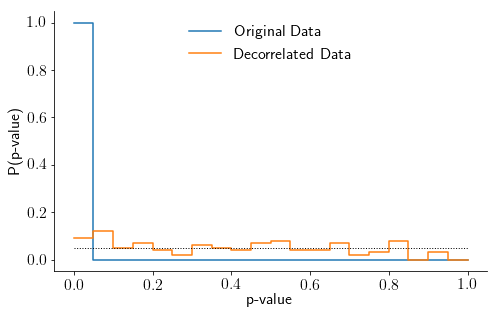

In [100]:
bins = np.linspace(0.0,1.0,21)

## plot the fitted exponent
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

## correlated
H,edges = np.histogram(list_pval,bins=bins)
H = np.append(H,0)
H = H/float(n_rep)
ax.step(edges,H,where='post',label='Original Data' )

## de-correlated
H,edges = np.histogram(list_pval_sub,bins=bins)
H = np.append(H,0)
H = H/float(n_rep)
ax.step(edges,H,where='post',label='Decorrelated Data' )

ax.plot([0.,1],[1/(len(bins)-1),1/(len(bins)-1)],lw=1,ls=':',color='black')

ax.legend(loc='upper center',frameon=False)
ax.set_ylabel('P(p-value)')
ax.set_xlabel('p-value',labelpad=0)